In [527]:
from gurobipy import *
from multidict import *
import networkx as NX
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [708]:
ID = ['BO','BR','CO','HA','MN','NA','NH','NL','PO','PR','SP','WO']
clients = [[100, 80],[15, 119],[76,145],[13,33],
           [80,132],[80,112],[0,0],[40,6],
           [120,139],[86,40],[20,60],[66,73]]
facs = [[100,80],[80,112],[86,40],[20,60],[66,73]]
demand = [425, 12, 43, 125, 110,86,129,28,66,320,220,182]
capacity = [2000,2000,2000,2000,2000]
fixed_costs = [10000,10000,10000,10000,10000]
numFacilities = len(facs)
numClients = len(clients)
P = 5
def flp(I,J,d,M,f,c):
    """flp -- model for the capacitated facility location problem
    Parameters:
        - I: set of customers
        - J: set of facilities
        - d[i]: demand for customer i
        - M[j]: capacity of facility j
        - f[j]: fixed cost for using a facility in point j
        - c[i,j]: unit cost of servicing demand point i from facility j
    Returns a model, ready to be solved.
    """

    model = Model("flp")
    x,y = {},{}
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))    
    model.update()
    
    for j in J:
        model.addConstr(quicksum(y[j] for j in J) == P, "P(%s)"%j)
    for i in I:
        model.addConstr(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i)

    for j in M:
        model.addConstr(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i)
        
    for (i,j) in x:
        model.addConstr(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j))        

    model.setObjective(
        quicksum(f[j]*y[j] for j in J) +
        quicksum(c[i,j]*x[i,j] for i in I for j in J),
        GRB.MINIMIZE)

    model.update()
    model.__data = x,y
    return model


def distance(a,b):
  dx = a[0] - b[0]
  dy = a[1] - b[1]
  return math.sqrt(dx*dx + dy*dy)

def make_data():
    I = []
    d = {}
    for i in range(numClients):
        I.append(i+1)
        d[i+1]=(demand[i])  
    
    J = []
    M,f = {},{}
    
    for j in range(numFacilities):
        J.append(j+1)
        M[j+1]=capacity[j]
        f[j+1]=fixed_costs[j]
    
    c = {}
    for k in range(numClients):
      for h in range(numFacilities):
        c[(k+1,h+1)] = np.floor(distance(clients[k], facs[h]))
    
    return I,J,d,M,f,c

Optimize a model with 82 rows, 65 columns and 270 nonzeros
Variable types: 60 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 4e+02]
Presolve removed 82 rows and 65 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 70593 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.059300000000e+04, best bound 7.059300000000e+04, gap 0.0000%
Optimal value= 70593.0
Facilities at nodes: [1, 2, 3, 4, 5]
Edges: [(1, 1), (3, 2), (5, 2), (6, 2), (9, 2), (8, 3), (10, 3), (2, 4), (4, 4), (7, 4), (11, 4), (12, 5)]


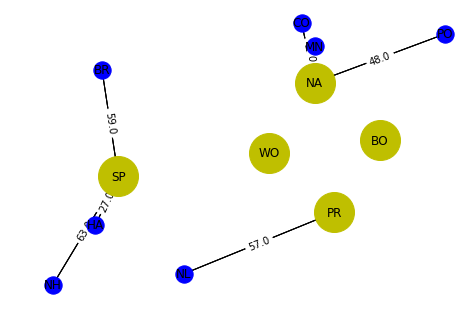

In [709]:
if __name__ == "__main__":
    I,J,d,M,f,c = make_data()
    model = flp(I,J,d,M,f,c)
    model.optimize()

    EPS = 1.e-6
    x,y = model.__data
    edges = [(i,j) for (i,j) in x if x[i,j].X > EPS]
    facilities = [j for j in y if y[j].X > EPS]
    print("Optimal value=",model.ObjVal)
    print("Facilities at nodes:",facilities)
    print("Edges:",edges)

    try: # plot the result using networkx and matplotlib
        
        plt.clf()
        G = NX.Graph()

        other = [j for j in y if j not in facilities]
        customers = ["c%s"%i for i in d]
        G.add_nodes_from(facilities,pos=[],weight=[])
        G.add_nodes_from(other,pos=[],weight=[])
        G.add_nodes_from(customers,pos=[],weight=[],ID=[])
        
        position={}
        for i in range(numClients):
            G.node["c%s"%(i+1)]['pos'] = (clients[i][0],clients[i][1])
            position["c%s"%(i+1)]=(clients[i][0],clients[i][1])
            G.node["c%s"%(i+1)]['weight']=demand[i]
            G.node["c%s"%(i+1)]['ID']=ID[i]
            
        position_facs = {}
        for i in range(len(facs)):
            G.node[i+1]['pos'] = (facs[i][0],facs[i][1])
            position[i+1] = (facs[i][0],facs[i][1])
            G.node[i+1]['weight'] = demand[i]
            
        position_other = {}
        for i in range(len(other)):
            k = other[i]
            G.node[i+1]['pos'] =facs[k-1] 
            position[k] = facs[k-1]
            G.node[i+1]['weight'] = demand[k-1]
        for i,j in edges:
            G.add_edge("c%s"%i, j,cd=np.round(c[i,j]),wd=np.round((c[i,j]*(x[i,j].X))/np.sum(demand),4))
        
        edge_labels = NX.get_edge_attributes(G,'cd')
        node_labels = NX.get_node_attributes(G,'ID')
        
        NX.draw(G,position,node_size=300,node_color="b",nodelist=customers,labels=node_labels)   
        NX.draw_networkx_edge_labels(G,position,edge_labels=edge_labels)       
        NX.draw(G,position,node_size=1600,node_color="y",nodelist=facilities)
        NX.draw(G,position,node_size=800,node_color="g",nodelist=other)
        plt.show()
    except ImportError:
        print("install 'networkx' and 'matplotlib' for plotting")

In [710]:
G.edges(data=True)

EdgeDataView([(1, 'c1', {'cd': 0.0, 'wd': 0.0}), (2, 'c3', {'cd': 33.0, 'wd': 0.8127}), (2, 'c5', {'cd': 20.0, 'wd': 1.26}), (2, 'c6', {'cd': 0.0, 'wd': 0.0}), (2, 'c9', {'cd': 48.0, 'wd': 1.8144}), (3, 'c8', {'cd': 57.0, 'wd': 0.9141}), (3, 'c10', {'cd': 0.0, 'wd': 0.0}), (4, 'c2', {'cd': 59.0, 'wd': 0.4055}), (4, 'c4', {'cd': 27.0, 'wd': 1.933}), (4, 'c7', {'cd': 63.0, 'wd': 4.6546}), (4, 'c11', {'cd': 0.0, 'wd': 0.0}), (5, 'c12', {'cd': 0.0, 'wd': 0.0})])

In [711]:
G.nodes(data=True)

NodeDataView({1: {'pos': (100, 80), 'weight': 425}, 2: {'pos': (80, 112), 'weight': 12}, 3: {'pos': (86, 40), 'weight': 43}, 4: {'pos': (20, 60), 'weight': 125}, 5: {'pos': (66, 73), 'weight': 110}, 'c1': {'pos': (100, 80), 'weight': 425, 'ID': 'BO'}, 'c2': {'pos': (15, 119), 'weight': 12, 'ID': 'BR'}, 'c3': {'pos': (76, 145), 'weight': 43, 'ID': 'CO'}, 'c4': {'pos': (13, 33), 'weight': 125, 'ID': 'HA'}, 'c5': {'pos': (80, 132), 'weight': 110, 'ID': 'MN'}, 'c6': {'pos': (80, 112), 'weight': 86, 'ID': 'NA'}, 'c7': {'pos': (0, 0), 'weight': 129, 'ID': 'NH'}, 'c8': {'pos': (40, 6), 'weight': 28, 'ID': 'NL'}, 'c9': {'pos': (120, 139), 'weight': 66, 'ID': 'PO'}, 'c10': {'pos': (86, 40), 'weight': 320, 'ID': 'PR'}, 'c11': {'pos': (20, 60), 'weight': 220, 'ID': 'SP'}, 'c12': {'pos': (66, 73), 'weight': 182, 'ID': 'WO'}})

In [712]:
cd = NX.get_edge_attributes(G,'cd')
print('Average Customer Distance = '+str('%.2f'%np.mean(list(cd.values()))))
wd = NX.get_edge_attributes(G,'wd')
print('Average Demand Distance = '+str('%.2f'%np.sum(list(wd.values()))))

b1,b2,b3,b4,b5 = [],[],[],[],[]
for k,v in cd.items():
    if v <= 25:
        b1.append(k)
    if (v > 25 and v <= 50):
        b2.append(k)
    if (v > 50 and v <= 75):
        b3.append(k)
    if (v > 75 and v <= 100):
        b4.append(k)
    elif (v > 100):
        b5.append(k)

c1,c2,c3,c4,c5 = [],[],[],[],[]

for i in range(len(b1)):
    c =G.node[b1[i][1]]['weight']
    c1.append(c)
for i in range(len(b2)):
    c =G.node[b2[i][1]]['weight']
    c2.append(c)
for i in range(len(b3)):
    c =G.node[b3[i][1]]['weight']
    c3.append(c)
for i in range(len(b4)):
    c =G.node[b4[i][1]]['weight']
    c4.append(c)
for i in range(len(b5)):
    c =G.node[b5[i][1]]['weight']
    c5.append(c)
    
print('\nPercent Demand within distance bracket: ')
print('distance <= 25 miles: '+ str('%.0f'%(np.sum(c1)/np.sum(demand)*100))+'%')
print('25 miles < distance <= 50 miles: '+ str('%.0f'%(np.sum(c2)/np.sum(demand)*100))+'%')
print('50 miles < distance <= 75 miles: '+ str('%.0f'%(np.sum(c3)/np.sum(demand)*100))+'%')
print('75 miles < distance <= 100 miles; '+ str('%.0f'%(np.sum(c4)/np.sum(demand)*100))+'%')
print('distance > 100 miles: '+ str('%.0f'%(np.sum(c5)/np.sum(demand)*100))+'%')

Average Customer Distance = 25.58
Average Demand Distance = 11.79

Percent Demand within distance bracket: 
distance <= 25 miles: 77%
25 miles < distance <= 50 miles: 13%
50 miles < distance <= 75 miles: 10%
75 miles < distance <= 100 miles; 0%
distance > 100 miles: 0%
